Мы предпологаем, что исходное распределение тока периодично $\implies$ исходя из этого предположения **мы сможем разложить в ряд Фурье** (и подогнать коэф-ты с помощью линейной регрессии на sin и cos преобразованиях current столбца)

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib import gridspec
import seaborn as sns

In [12]:
# 1. Генерация синтетических данных с аномалиями
np.random.seed(42)
time = pd.date_range(start="2023-01-01", periods=1000, freq="s")
current = np.sin(np.arange(1000) / 10) + np.random.normal(0, 0.05, 1000)
current[200:220] = 0.1  # обрыв цепи
current[400:430] += np.linspace(0, 0.8, 30)  # перегрузка

df = pd.DataFrame({"time": time, "current": current})
df['t'] = np.arange(len(df))

In [13]:
df

,time,current,t
0,2023-01-01 00:00:00,0.024836,0
1,2023-01-01 00:00:01,0.092920,1
2,2023-01-01 00:00:02,0.231054,2
3,2023-01-01 00:00:03,0.371672,3
4,2023-01-01 00:00:04,0.377711,4
...,...,...,...
995,2023-01-01 00:16:35,-0.871850,995
996,2023-01-01 00:16:36,-0.712312,996
997,2023-01-01 00:16:37,-0.706540,997
998,2023-01-01 00:16:38,-0.696147,998


In [14]:
# 2. Оценка основной частоты через FFT
fft_vals = np.fft.rfft(df['current'])
freqs = np.fft.rfftfreq(len(df), d=1)
freq = freqs[np.argmax(np.abs(fft_vals[1:])) + 1]

In [15]:
print(freq)

0.016


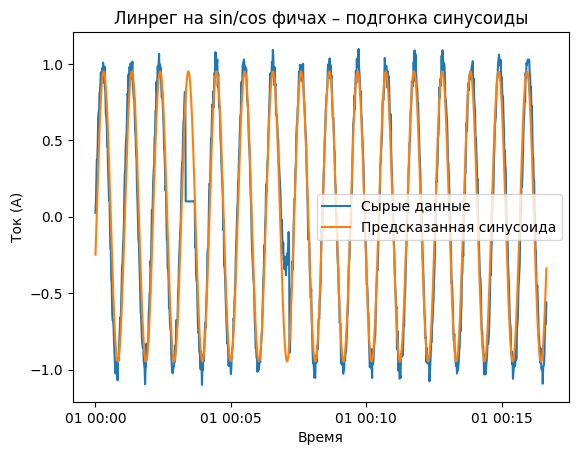

In [16]:
# 3. Создание синус/косинус фичей
X = np.column_stack([
    np.sin(2 * np.pi * freq * df['t']),
    np.cos(2 * np.pi * freq * df['t'])
])
y = df['current']

model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Визуализируем
plt.figure()
plt.plot(df['time'], y, label='Сырые данные')
plt.plot(df['time'], y_pred, label='Предсказанная синусоида')
plt.xlabel('Время')
plt.ylabel('Ток (A)')
plt.title('Линрег на sin/cos фичах – подгонка синусоиды')
plt.legend()
plt.show()


Уже отсюда видно, что мы неплохо восстановили исходную зависимость. Для детекции обрыва цепи давайте рассмотрим разницу между предсказанным значением и сырыми данными. Если разница будет слишком сильная то будем помечать это как аномалия

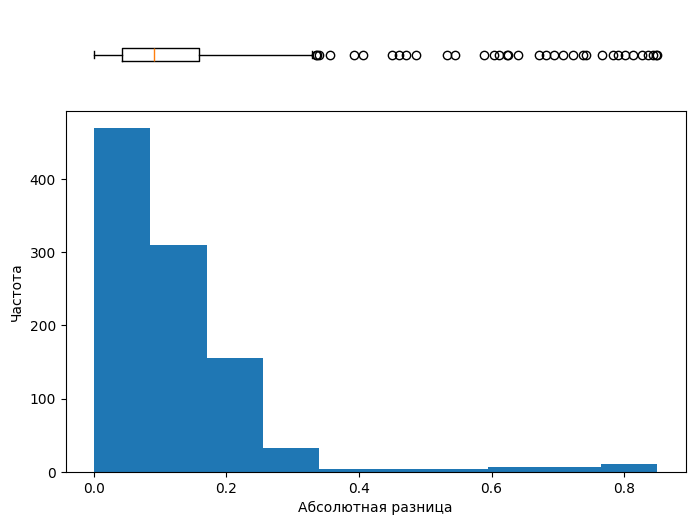

In [17]:
absolute_difference_between_true_and_predicted = abs(df['current'] - y_pred)

fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4], hspace=0.05)
ax_box = fig.add_subplot(gs[0])
ax_box.boxplot(absolute_difference_between_true_and_predicted, vert=False)
ax_box.axis('off')  # убираем лишние оси, чтоб было чище
ax_hist = fig.add_subplot(gs[1], sharex=ax_box)
ax_hist.hist(absolute_difference_between_true_and_predicted)
ax_hist.set_xlabel('Абсолютная разница')
ax_hist.set_ylabel('Частота')

plt.show()


In [18]:
df['anomaly'] = 1
mask = absolute_difference_between_true_and_predicted > 0.35
df.loc[mask, 'anomaly'] = -1

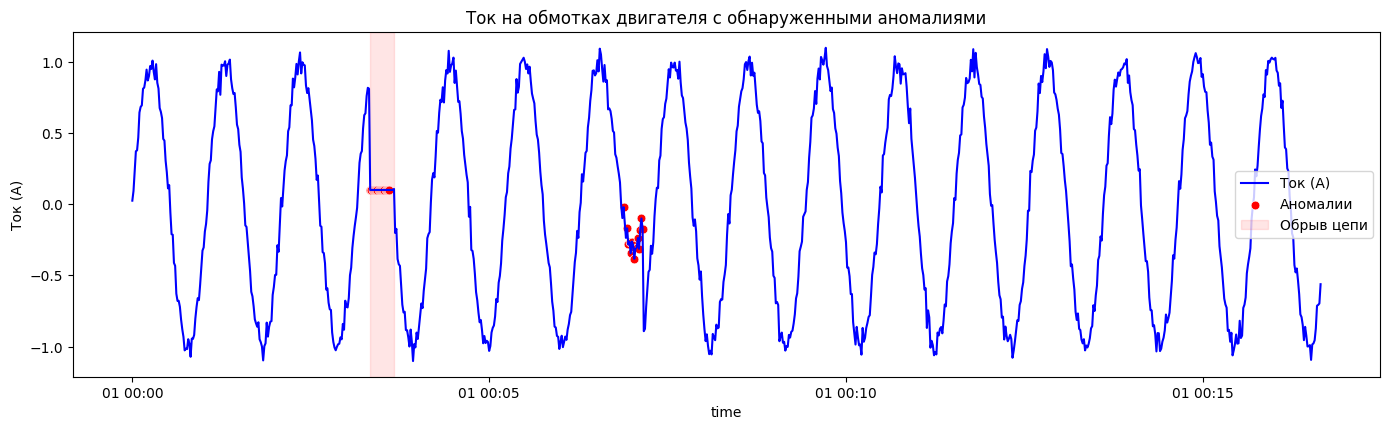

=== Эффективность детекции ===
Обрыв цепи (200-220): 17/20


In [19]:
# 5. Визуализация
plt.figure(figsize=(14, 8))

# График тока с аномалиями
plt.subplot(2, 1, 1)
sns.lineplot(data=df, x="time", y="current", color="blue", label="Ток (А)")
sns.scatterplot(data=df[df["anomaly"] == -1], x="time", y="current",
                color="red", s=40, label="Аномалии")
plt.axvspan(df["time"][200], df["time"][220], color="red", alpha=0.1, label="Обрыв цепи")
plt.title("Ток на обмотках двигателя с обнаруженными аномалиями")
plt.ylabel("Ток (А)")
plt.legend()

plt.tight_layout()
plt.show()

# 6. Проверка эффективности
print("=== Эффективность детекции ===")
print(f"Обрыв цепи (200-220): {df[(df['anomaly'] == -1) & (df.index >= 200) & (df.index < 220)].shape[0]}/20")